In [1]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
from tensorflow.python import keras
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv1D, LSTM, Dense, Flatten, MaxPooling1D
from keras.models import Sequential
from keras.losses import Huber
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

# Open the NetCDF file
dataset = nc.Dataset('mascons.nc')

# Get the variable 'lwe_thickness' from the dataset
lwe_thickness_variable = dataset.variables['lwe_thickness']

# Read the data from the variable into a multidimensional NumPy array
lwe_thickness_data = lwe_thickness_variable[:]

# Get the time variable from the dataset
time_variable = dataset.variables['time']

# Read the time values into a NumPy array
time_values = time_variable[:]

# Close the NetCDF file
dataset.close()

In [2]:
time = []
thickness = []

#Time and lwe Data at lon=0, lat=0
for time_index in range(lwe_thickness_data.shape[0]):
  
  current_value = lwe_thickness_data[time_index, 0, 0]
  
  current_time = time_values[time_index]
  
  time.append(time_index)

  thickness.append(current_value)

steps = np.array(time)
lwe =  np.array(thickness)

In [3]:
from sklearn.preprocessing import StandardScaler

# Standardize the data using Z-score normalization
scaler = StandardScaler()
scaled_data = scaler.fit_transform(lwe.reshape(-1, 1))

'''
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(lwe.reshape(-1, 1))
'''

# Split the data into training and testing sets
train_size = int(len(lwe) * 0.7)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Create sequences and labels for training the model
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

'''
# Build the CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
'''

# Define the sequence length for creating input sequences for the LSTM model
sequence_length = 6

# Create sequences and labels for training and testing sets
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape the input data to fit the CNN input requirements
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#Building CNN-LSTM-LSTM model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, activation='relu', return_sequences=True))  # Use return_sequences=True for stacked LSTM layers
model.add(LSTM(64, activation='relu'))  # Adding a second LSTM layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Evaluate the model on the test set
mse = model.evaluate(X_test, y_test, verbose=0)
print("Mean Squared Error on Test Set:", mse, "Sequence Length:", sequence_length)

Epoch 1/100
5/5 [==============================] - 1s 78ms/step - loss: 0.6589
Epoch 2/100
5/5 [==============================] - 0s 84ms/step - loss: 0.6344
Epoch 3/100
5/5 [==============================] - 0s 70ms/step - loss: 0.6100
Epoch 4/100
5/5 [==============================] - 0s 82ms/step - loss: 0.5787
Epoch 5/100
5/5 [==============================] - 0s 91ms/step - loss: 0.5345
Epoch 6/100
5/5 [==============================] - 0s 67ms/step - loss: 0.4698
Epoch 7/100
5/5 [==============================] - 0s 76ms/step - loss: 0.3725
Epoch 8/100
5/5 [==============================] - 0s 58ms/step - loss: 0.2409
Epoch 9/100
5/5 [==============================] - 0s 64ms/step - loss: 0.0783
Epoch 10/100
5/5 [==============================] - 0s 65ms/step - loss: 0.0458
Epoch 11/100
5/5 [==============================] - 0s 56ms/step - loss: 0.0442
Epoch 12/100
5/5 [==============================] - 0s 55ms/step - loss: 0.0354
Epoch 13/100
5/5 [==============================]

In [17]:
# Make predictions on future data
#future_data = scaled_data[-sequence_length:]  # Last 'sequence_length' data points as initial input
#predictions = []

# Define the number of initial data points to include in the input
initial_data_points = 18
# Make predictions on future data
future_data = scaled_data[-(sequence_length + initial_data_points):-initial_data_points]
# Initialize the predictions list with the initial_data_points
predictions = list(future_data[-initial_data_points:])

# Define the number of future time steps you want to predict
num_steps_to_predict = 20

for _ in range(num_steps_to_predict):
    input_data = future_data[-sequence_length:].reshape(1, sequence_length, 1)
    prediction = model.predict(input_data)[0][0]
    predictions.append(prediction)
    future_data = np.append(future_data, prediction)
    future_data = future_data[1:]

# Inverse transform the predictions to obtain the original scale
predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Print the predicted values for future time steps
print("Predicted Values for Future Time Steps:")
print(predicted_values)


1/1 [==============================] - 0s 34ms/step
Predicted Values for Future Time Steps:
[[24.7921459 ]
 [18.82575026]
 [23.3318656 ]
 [22.42703808]
 [29.18181071]
 [26.89545615]
 [23.35584467]
 [24.65748877]
 [24.98555253]
 [24.98037484]
 [23.75375758]
 [22.95252429]
 [22.41036535]
 [22.0872921 ]
 [21.44695968]
 [20.82492152]
 [20.20447178]
 [19.70492714]
 [19.22552013]
 [18.7519627 ]
 [18.27812258]
 [17.85330916]
 [17.45972455]
 [17.10240056]
 [16.76559371]
 [16.45678589]]


C:\Users\user\AppData\Local\Temp/ipykernel_22620/3424417725.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


In [5]:
print(len(predicted_values))

26


2/2 [==============================] - 0s 38ms/step
Mean Squared Error (MSE): 10.084124349315124
Mean Absolute Error (MAE): 2.6929304250096053


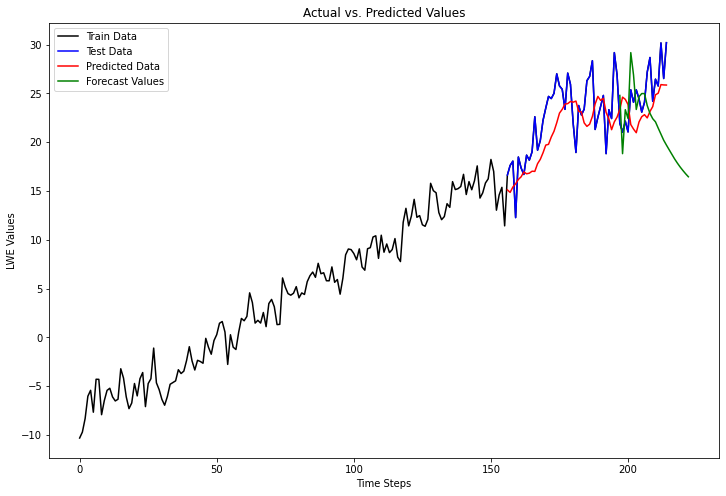

In [20]:
dummy = 215 + 8
temp = np.arange(dummy)
temp = temp[215-initial_data_points:dummy]

y_pred_steps = np.arange(215)
y_pred_steps = y_pred_steps[156:215].reshape(-1,1)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to obtain the original scale
y_pred_actual_scale = scaler.inverse_transform(y_pred)
y_test_actual_scale = scaler.inverse_transform(y_test)

# Calculate the Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = np.mean((y_pred_actual_scale - y_test_actual_scale) ** 2)
mae = np.mean(np.abs(y_pred_actual_scale - y_test_actual_scale))

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

# Plot the actual and predicted values
plt.figure(figsize=(12, 8))
#plt.scatter(steps[0:-(len(X_test))], lwe[0:-(len(X_test))], label='Full Data', color='black', s=10)
plt.plot(lwe[:215],label='Train Data', color='black')
plt.plot(y_pred_steps, y_test_actual_scale, label='Test Data', color='blue')
plt.plot(y_pred_steps, y_pred_actual_scale, label='Predicted Data', color='red')
plt.plot(temp, predicted_values,label='Forecast Values', color='green')
plt.xlabel('Time Steps')
plt.ylabel('LWE Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()
